In [ ]:
import numpy as np
import torch.optim as optim

In [ ]:
import numpy as np

class Petri_net(object):
    def __init__(self,mat_pre,mat_post,m0):
        self.mat_pre=mat_pre
        self.mat_post=mat_post
        self.mat=self.mat_post-self.mat_pre
        self.m=m0

    def is_tansition(self):
        self.tran=(self.m[:,None]>=self.mat_pre).all(0).nonzero()[0]   
        return  np.where(len(self.tran),True,False)  

    def firing(self,T):
        self.m=self.m+self.mat[:,T]     


mat_pre = np.loadtxt("D:\\petri_learning\\c.pre.txt")
mat_post = np.loadtxt("D:\\petri_learning\\c.post.txt")
m0 = np.loadtxt("D:\\petri_learning\\m0.txt") 
petri_net=Petri_net(mat_pre,mat_post,m0)  
print(petri_net.mat) 
print("初始标识：",petri_net.m)
for x in range(3):
    if petri_net.is_tansition():  #判断是否存在可激发变迁
        tran_enable=np.random.choice(petri_net.tran)  #随机选择一个可激发变迁
    else:
        print("\n无可激发变迁！")
        break
    petri_net.firing(tran_enable)    #激发变迁
    print("\n可激发变迁：",petri_net.tran+1)
    print("激发变迁：",tran_enable+1)
    print("当前标识：",petri_net.m)

petri_net.m



In [ ]:

(petri_net.m[:,None]>=petri_net.mat_pre).all(0)

In [ ]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt 
from torch_geometric.data import Data

class Petri_net(object):
    def __init__(self,mat_pre,mat_post,m0):
        self.__mat_pre=mat_pre
        self.__mat_post=mat_post
        self.__mat=self.__mat_post-self.__mat_pre
        self.m=m0

    def get_tansition(self,M):  
        self.Te=(M[:,None]>=self.__mat_pre).all(0).nonzero()[0]
        return self.Te
        
    def is_empty_Te(self):
        return  np.where(len(self.Te),True,False)

    def firing(self,M,T):
        self.m=M+self.__mat[:,T] 
        return self.m

class Petri_net_to_graph(Petri_net):
    def __init__(self,mat_pre,mat_post,m0):
        super().__init__(mat_pre,mat_post,m0)
        self.Vnew={0:m0}

    def is_empty_Vnew(self):  ##判断Vnew是否为空
        return np.where(len(self.Vnew),True,False)

    def Vnew_delete(self,node_name): ##从Vnew删除选择节点
        self.Vnew.pop(node_name)

    def T_delete(self,t):     ##并从Te中删除
        self.Te=[x for x in self.Te if x!=t]

    def node_choose(self):    ##从Vnew选择新节点
        #temp=np.random.choice(list(self.Vnew.keys()))
        temp=list(self.Vnew.keys())[0]
        return temp

    def Te_choose(self):    ##从Te选择一个可激发变迁
        ##temp=np.random.choice(self.Te)
        temp=self.Te[0]
        return temp

    def is_new_node(self,m_new,V):  ##判断新节点是否在V中出现过
        temp=np.array([list(item) for item in V.values()])
        return np.where((temp==m_new[:None]).all(1).nonzero()[0].size,False,True)

    def append_vnew(self,node_name,m):
        self.Vnew.update({node_name:m})

class Graph_reach(object):
    def __init__(self,node_name_init,m0):
        self.v={node_name_init:m0}
        self.edge = {node_name_init:[]}
        self.weigh={}
        self.node_name=node_name_init

    def append_v_node(self,m):
        self.node_name+=1
        self.v.update({self.node_name:m})

    def append_head_node(self,head_node):
        self.edge.update({head_node:[]})

    def append_next_node(self,head_node, node_name):
        self.edge[head_node].append(node_name)

    def append_weigh(self,head_node,next_node,t):
        self.weigh.update({(head_node,next_node):t})

    def get_head_node(self,node_name):
        return [k for k, v in self.edge.items() if node_name in v]

    def get_next_node(self,node_name):
        return self.edge[node_name]

    def get_node_m(self,node_name):
        return self.v[node_name]

    def get_weigh(self,head_node,next_node):
        return self.weigh[(head_node,next_node)]

    def get_node_name(self,Dict,m):
        return [k for k, v in Dict.items() if (v == m).all(0)][0]

mat_pre = np.loadtxt("D:\\petri_learning\\c.pre.txt")
mat_post = np.loadtxt("D:\\petri_learning\\c.post.txt")
m0 = np.loadtxt("D:\\petri_learning\\m0.txt") 
net_to_graph=Petri_net_to_graph(mat_pre,mat_post,m0)
graph=Graph_reach(0,m0)
G = nx.DiGraph()
while(net_to_graph.is_empty_Vnew()):                                                    #       判断Vnew是否为空  进入第一层循环
    new_node=net_to_graph.node_choose()                                                 #步骤4  从任意Vnew中选取新节点m
    net_to_graph.Te=net_to_graph.get_tansition(graph.v[new_node])                       #步骤5  获得m可激发变迁Te
    net_to_graph.Vnew_delete(new_node)                                                  #       并删除Vnew
    graph.append_head_node(new_node)
    while(net_to_graph.is_empty_Te()):                                                  #       判断Te是否为空    进入第二层循环
        tran_enable=net_to_graph.Te_choose()                                            #步骤6  从Te中随机选择一个可激发变迁
        net_to_graph.T_delete(tran_enable)                                              #       并将该变迁从Te中删除
        net_to_graph.m=net_to_graph.firing(graph.v[new_node],tran_enable)               #步骤7  激发变迁  得到m'
        if net_to_graph.is_new_node(net_to_graph.m,graph.v):                            #步骤8  判断m'是不是新出现节点
            graph.append_v_node(net_to_graph.m)                                         #       是  则更新V_new  V 
            net_to_graph.append_vnew(graph.node_name,net_to_graph.m)                    #       更新V
        graph.append_next_node(new_node,graph.get_node_name(graph.v,net_to_graph.m))          #       更新E
        graph.append_weigh(new_node,graph.get_node_name(graph.v,net_to_graph.m),tran_enable)  #       更新W 

edge_index=[k for k,v in graph.weigh.items()]
#graph_data=Data.from_dict()
G.add_edges_from(edge_index)
#G.add_weighted_edges_from(graph.weigh)
#plt.xlim(-4, 6)                     #设置X轴坐标范围
#plt.ylim(-3, 4)                     #设置Y轴坐标范围
pos = {
        0:(0,0),
        1:(0.5,-1),
        2:(-0.5,-1),
        3:(1,-2),
        4:(0,-2),
        5:(-1,-2),
        6:(0.5,-3),
        7:(1.5,-3),
        8:(-0.5,-3),
        9:(2,-4),
        10:(1,-4),
        11:(0,-4),
        12:(2.5,-5),
        13:(1.5,-5),
        14:(0.5,-5),
        15:(-0.5,-5),
        16:(1,-6),
        17:(2,-6),
        18:(0,-6),
        19:(-1,-6),
        20:(1.5,-7),
        21:(-0.5,-7),
        22:(-1.5,-7),
        23:(-1,-8),
        24:(-2,-8),
        25:(-1.5,-9),
        26:(-0.5,-9),
        27:(-2.5,-9),
        28:(-1,-10),
        29:(-3,-10),
        30:(-3.5,-11)
        }
plt.figure(figsize=(8,10))
#pos = nx.spring_layout(G, seed=3)
nx.draw(
        G,
        pos=pos,
        node_color = 'red',             # 顶点颜色
        edge_color = 'black',           # 边的颜色
        with_labels = True,             # 显示顶点标签
        font_size =15,                  # 文字大小
        node_size =400                  # 顶点大小
    
       )
#plt.show()
graph.edge

Data(edge_index=[48, 2], v=[31, 7], edge_weight=[48, 3], label=[31], num_nodes=31)


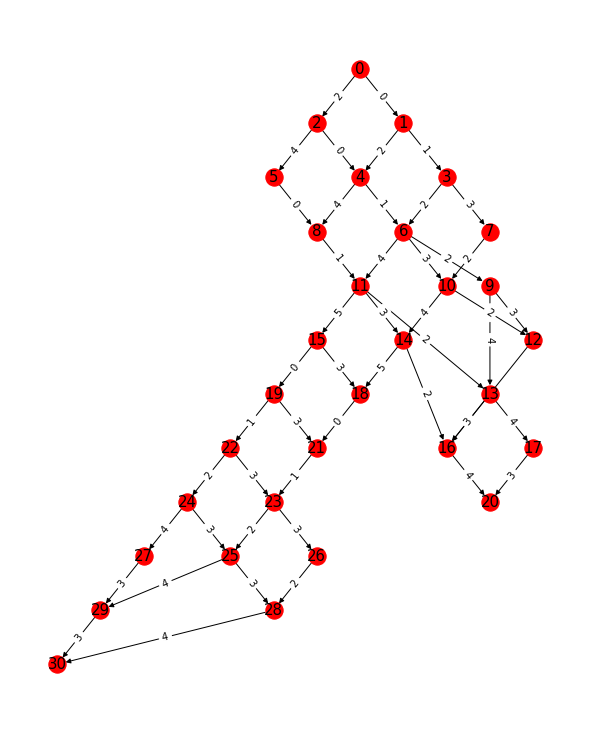

In [217]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt 
from torch_geometric.data import Data

class Petri_net(object):
    def __init__(self,mat_pre,mat_post,m0):
        self.__mat_pre=mat_pre
        self.__mat_post=mat_post
        self.__mat=self.__mat_post-self.__mat_pre
        self.m=m0

    def get_tansition(self,M):  
        self.Te=(M[:,None]>=self.__mat_pre).all(0).nonzero()[0]
        return self.Te
        
    def is_empty_Te(self):
        return  np.where(len(self.Te),True,False)

    def firing(self,M,T):
        self.m=M+self.__mat[:,T] 
        return self.m

    @classmethod
    def mat_imput(cls,mat_pre_path,mat_post_path,m0_path):
        pre = np.loadtxt(mat_pre_path,dtype=int)
        post = np.loadtxt(mat_post_path,dtype=int)
        m0 = np.loadtxt(m0_path,dtype=int) 
        return cls(pre,post,m0)

class Petri_net_to_graph(Petri_net):
    def __init__(self,mat_pre,mat_post,m0):
        super().__init__(mat_pre,mat_post,m0)
        self.Vnew=np.array([m0])

    def is_empty_Vnew(self):  ##判断Vnew是否为空
        return np.where(len(self.Vnew),True,False)

    def Vnew_delete(self,): ##从Vnew删除选择节点
        self.Vnew=np.delete(self.Vnew,0,axis=0)

    def T_delete(self,t):     ##并从Te中删除
        self.Te=np.delete(self.Te,0,axis=0)

    def node_choose(self):    ##从Vnew选择新节点
        temp=self.Vnew[0]
        return temp

    def Te_choose(self):    ##从Te选择一个可激发变迁
        temp=self.Te[0]
        return temp

    def is_new_node(self,V,m_new):  ##判断新节点是否在V中出现过
        temp=self.compare(V,m_new)
        return np.where(temp.size,False,True)

    def append_vnew(self,m):
        self.Vnew=np.append(self.Vnew,m.reshape(1,-1),axis=0)

    def compare(self,x,y):
        return (x==y[:None]).all(1).nonzero()[0]

class Graph_reachable(object):
    def __init__(self,m0):
        self.node=np.array([m0])
        self.edge = np.array([[],[]],dtype=int)
        self.weight=np.array([],dtype=int)
        self.node_num=1
        self.label=np.array([self.node_num-1],dtype=int)
        self.adj_list = {0:[]}

    def append_node(self,m):
        self.node_num=self.node_num+1
        self.label=np.append(self.label,[self.node_num-1],axis=0)
        self.node=np.append(self.node,m.reshape(1,-1),axis=0)

    def append_edge(self,head_node,next_node):
        edge=np.append(head_node.reshape(1,-1),next_node.reshape(1,-1),axis=0)
        self.edge=np.append(self.edge,edge,axis=1)

    def append_weigh(self,t):
        self.weight=np.append(self.weight,np.array([t]),axis=0)
    def append_head_node(self,head_node):
        self.adj_list.update({head_node[0]:[]})

    def append_next_node(self,head_node, node_name):
        self.adj_list[head_node[0]].append(node_name[0])

    def data_into_graph(self):
        self.weight=np.append(self.edge,self.weight.reshape(1,-1),axis=0)
        graph_dict = {
            'v':self.node,
            'edge_index': self.edge.transpose(),
            'edge_weight': self.weight.transpose(),
            'label': self.label,
            'num_nodes': self.node_num,
            #'adj_list':self.adj_list
        }
        return Data.from_dict(graph_dict)
pos = {
        0:(0,0),
        1:(0.5,-1),
        2:(-0.5,-1),
        3:(1,-2),
        4:(0,-2),
        5:(-1,-2),
        6:(0.5,-3),
        7:(1.5,-3),
        8:(-0.5,-3),
        9:(1.5,-4),
        10:(1,-4),
        11:(0,-4),
        12:(2,-5),
        13:(1.5,-6),
        14:(0.5,-5),
        15:(-0.5,-5),
        16:(1,-7),
        17:(2,-7),
        18:(0,-6),
        19:(-1,-6),
        20:(1.5,-8),
        21:(-0.5,-7),
        22:(-1.5,-7),
        23:(-1,-8),
        24:(-2,-8),
        25:(-1.5,-9),
        26:(-0.5,-9),
        27:(-2.5,-9),
        28:(-1,-10),
        29:(-3,-10),
        30:(-3.5,-11)
        }

net_to_graph=Petri_net_to_graph.mat_imput("c.pre.txt","c.post.txt","m0.txt")
graph=Graph_reachable(net_to_graph.m)
G = nx.DiGraph()
while(net_to_graph.is_empty_Vnew()):                                #       判断Vnew是否为空  进入第一层循环
    new_node=net_to_graph.node_choose()                             #步骤4  从Vnew中选取新节点m
    net_to_graph.Te=net_to_graph.get_tansition(new_node)            #步骤5  获得m可激发变迁Te
    head_node=net_to_graph.compare(graph.node,new_node)
    net_to_graph.Vnew_delete()                                      #       并删除Vnew
    graph.append_head_node(head_node)                              
    while(net_to_graph.is_empty_Te()):                              #       判断Te是否为空    进入第二层循环
        tran=net_to_graph.Te_choose()                               #步骤6  从Te中选择一个可激发变迁
        net_to_graph.T_delete(tran)                                 #       并将该变迁从Te中删除
        net_to_graph.m=net_to_graph.firing(new_node,tran)           #步骤7  激发变迁  得到m'
        if net_to_graph.is_new_node(graph.node,net_to_graph.m):     #步骤8  判断m'是不是新出现节点                                        
            net_to_graph.append_vnew(net_to_graph.m)                #       是  则更新V_new  V 
            graph.append_node(net_to_graph.m)                       #       更新V      
        next_node=net_to_graph.compare(graph.node,net_to_graph.m)
        graph.append_next_node(head_node,next_node)
        graph.append_edge(head_node,next_node)                      #       更新E
        graph.append_weigh(tran)                                    #       更新W 

graph_data=graph.data_into_graph()
print(graph_data)
G.add_weighted_edges_from(graph_data.edge_weight)
plt.figure(figsize=(8,10))
#pos = nx.spring_layout(G, seed=3)
nx.draw(G,pos=pos,node_color='red',edge_color='black',
          with_labels=True,font_size =15,node_size =300)
edge_labels=nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels)
plt.show()

array([[1, 0, 1, 0, 0, 2, 0],
       [0, 1, 1, 0, 0, 2, 0],
       [1, 0, 0, 0, 1, 2, 0],
       [0, 0, 2, 1, 0, 2, 0],
       [0, 1, 0, 0, 1, 2, 0],
       [1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 2, 0],
       [0, 0, 2, 0, 0, 3, 0],
       [0, 1, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 2, 2, 0],
       [0, 0, 1, 0, 1, 3, 0],
       [0, 0, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 2, 3, 0],
       [0, 0, 0, 1, 1, 1, 1],
       [0, 0, 1, 0, 0, 2, 1],
       [1, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 2, 1],
       [0, 0, 0, 1, 0, 0, 2],
       [1, 0, 0, 0, 0, 2, 0],
       [0, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 2],
       [0, 1, 0, 0, 0, 2, 0],
       [0, 0, 1, 2, 0, 1, 0],
       [0, 0, 1, 1, 0, 2, 0],
       [0, 0, 0, 2, 1, 1, 0],
       [0, 0, 0, 1, 1, 2, 0],
       [0, 0, 1, 0, 0, 3, 0],
       [0, 0, 0, 2, 0, 0, 1],
       [0, 0, 0, 0, 1, 3, 0],
       [0, 0, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 2, 1]])

In [142]:
graph_data.edge_index,graph_data.lable,graph_data.node,graph_data.weight

(array([[ 0,  1],
        [ 0,  2],
        [ 1,  3],
        [ 1,  4],
        [ 2,  4],
        [ 2,  5],
        [ 3,  6],
        [ 3,  7],
        [ 4,  6],
        [ 4,  8],
        [ 5,  8],
        [ 6,  9],
        [ 6, 10],
        [ 6, 11],
        [ 7, 10],
        [ 8, 11],
        [ 9, 12],
        [ 9, 13],
        [10, 12],
        [10, 14],
        [11, 13],
        [11, 14],
        [11, 15],
        [12, 16],
        [13, 16],
        [13, 17],
        [14, 16],
        [14, 18],
        [15, 19],
        [15, 18],
        [16, 20],
        [17, 20],
        [18, 21],
        [19, 22],
        [19, 21],
        [21, 23],
        [22, 24],
        [22, 23],
        [23, 25],
        [23, 26],
        [24, 25],
        [24, 27],
        [25, 28],
        [25, 29],
        [26, 28],
        [27, 29],
        [28, 30],
        [29, 30]], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 2

In [18]:
from node2vec import Node2Vec

In [38]:
node2vec = Node2Vec(G, 
                    dimensions=32,  # 嵌入维度
                    p=1,            # 回家参数
                    q=2,          # 外出参数
                    walk_length=10, # 随机游走最大长度
                    num_walks=600,  # 每个节点作为起始节点生成的随机游走个数
                    workers=4       # 并行线程数
                   )

Computing transition probabilities: 100%|██████████| 138/138 [00:00<00:00, 5749.22it/s]


In [39]:
model = node2vec.fit(window=3,    # Skip-Gram窗口大小
                     min_count=1,  # 忽略出现次数低于此阈值的节点（词）
                     batch_words=4 # 每个线程处理的数据量
                    )

In [40]:
X = model.wv.vectors

In [45]:
model.wv.most_similar('3')

[('0', 0.7823112607002258),
 ('1', 0.7520200610160828),
 ('2', 0.712483823299408),
 ('38', 0.6163062453269958),
 ('8', 0.5751577019691467),
 ('9', 0.5711944103240967),
 ('6', 0.5657545924186707),
 ('48', 0.5407390594482422),
 ('58', 0.52146315574646),
 ('46', 0.5196097493171692)]

KeyError: 2

In [72]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30))

[]